In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer   
import textwrap
import seaborn as sns
import preamble
import torch
import src.constants as const
import statsmodels.formula.api as smf
import os
import scipy.stats as stats

In [2]:
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [3]:
df_CHES = pd.read_parquet(const.PATH_MIGRATION_CHES)

In [4]:
MODEL_NAME = "google/embeddinggemma-300m" # previously chosen embedding model
OUTDATED_MODELS = ["jinaai/jina-embeddings-v3",
            "jinaai/jina-embeddings-v4",
            "Snowflake/snowflake-arctic-embed-l-v2.0",
            "BAAI/bge-m3", 
            'sentence-transformers/all-MiniLM-L6-v2', 
            'sentence-transformers/all-mpnet-base-v2',
            'Qwen/Qwen3-Embedding-0.6B']

In [5]:
# import dataframe of migration speeches with embeddings
df = pd.read_parquet(const.PATH_MIGRATION_SPEECHES_EMBEDDED)

In [6]:
# delete all columns of outdated models to save memory
for outdated_model in OUTDATED_MODELS:
    if outdated_model in df.columns:
        del df[outdated_model]

In [7]:
# join df_CHES with df on 'Unnamed: 0' column
df = df_CHES.merge(df, on='Unnamed: 0')
del df_CHES

In [8]:
# inspect the dataframe
df.head()

Unnamed: 0                      speaker_x  \
0      292003                   Amjad Bashir   
1      292025                Monika Smolková   
2      292004            Miguel Arias Cañete   
3      291861               Kristina Winberg   
4      291519  Ελισσάβετ Βόζεμπεργκ-Βρυωνίδη   

                                              text_x     date_x  \
0  Mr Arias, we have heard about the injustice do... 2014-07-02   
1  – Taliansko predstavilo veľmi ambiciózny plán ... 2014-07-02   
2  Sí, efectivamente, para luchar contra la inmig... 2014-07-02   
3  Fru talman! Schengenavtalet ingicks i en anda ... 2014-07-14   
4  Αξιότιμε κύριε Juncker, στις προτεραιότητές σα... 2014-07-15   

                                            agenda_x  speechnumber_x  \
0  12. Programme of activities of the Italian Pre...              41   
1  12. Programme of activities of the Italian Pre...              63   
2  12. Programme of activities of the Italian Pre...              42   
3  13. One-minute speeches on matters of politica...              24   
4  5. Statement by the candidate for President of...              25   

  procedure_ID_x  partyfacts_ID_x  period_x  chair_x  ...  \
0                          6404.0         8    False  ...   
1                          6399.0         8    False  ...   
2                          6398.0         8    False  ...   
3                          6404.0         8    False  ...   
4                          6398.0         8    False  ...   

                  block_y         party_y  migration_prob_y  \
0         (extreme)_right  EDD/INDDEM/EFD          0.257913   
1       social_democratic         PSE/S&D          0.323411   
2  christian_conservative             PPE          0.494101   
3         (extreme)_right  EDD/INDDEM/EFD          0.700463   
4  christian_conservative             PPE          0.604105   

                          google/embeddinggemma-300m  \
0  [-0.069285564, 0.010856343, -0.04336025, 0.041...   
1  [-0.042545278, -0.006075105, 0.01914387, 0.020...   
2  [-0.047469348, 0.016370948, -0.0141231995, -0....   
3  [-0.07739339, 0.066338874, -0.0071556233, 0.01...   
4  [-0.037995864, 0.029239077, -0.05127566, 0.035...   

                                            document  \
0  [-0.07909732, 0.006641312, -0.04913974, 0.0337...   
1  [-0.041928854, -0.006218076, 0.015627557, 0.02...   
2  [-0.037770215, 0.020164201, -0.022457914, -0.0...   
3  [-0.083562165, 0.054563407, -0.014938202, 0.02...   
4  [-0.035637878, 0.030819448, -0.056643542, 0.03...   

                                          Clustering  \
0  [-0.18880829, 0.0087186, -0.055640258, 0.01384...   
1  [-0.17524645, -0.0065418324, -0.02066971, 0.00...   
2  [-0.1949541, -0.0058559934, -0.032146756, -0.0...   
3  [-0.19063814, 0.017127959, -0.021010902, -0.01...   
4  [-0.13603933, 0.013348386, -0.03438253, 0.0108...   

                                      Classification  \
0  [-0.1220215, 0.008495812, -0.03303916, 0.04014...   
1  [-0.12367173, 0.006611916, 0.006212096, 0.0170...   
2  [-0.11703083, 0.0332698, -0.023145925, -0.0117...   
3  [-0.14881086, 0.038516752, 0.01033903, 0.00567...   
4  [-0.08728084, 0.020681914, -0.03615619, 0.0450...   

                                                 STS  \
0  [-0.111873165, 0.018456344, -0.02060441, 0.046...   
1  [-0.08861599, 0.032430645, 0.019701384, 0.0383...   
2  [-0.0868288, 0.05383187, -0.0097864345, -0.005...   
3  [-0.12723538, 0.073258504, -0.0050462605, 0.04...   
4  [-0.06727801, 0.05521464, -0.034754075, 0.0592...   

                                           Retrieval  \
0  [-0.06803559, 0.003126187, -0.049837667, 0.027...   
1  [-0.058537114, -0.014022314, 0.009153899, 0.00...   
2  [-0.050628018, 0.021563467, -0.024621004, -0.0...   
3  [-0.103088, 0.04727008, -0.009968939, 0.007238...   
4  [-0.049649112, 0.029460197, -0.0516613, 0.0282...   

                                       Summarization  
0  [-0.11358194, 0.013040993, -0.034991644, 0.034...  


In [9]:
# load the google embedding model
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu" 
model = SentenceTransformer(MODEL_NAME, trust_remote_code=True).to(device)

In [10]:
# hard-code migration narratives identified in Seiger et al., 2025 (Report from Joint Research Centre of the European Commission)
queries_jrc = {
    "immigrants_as_problematic" : 
    [
    "Immigration is a threat to the European way of life and identity",
    "Arabs and Muslims are a cultural or social threat",
    "Certain immigrants are unwilling or incapable to integrate"],
    "immigrants_as_threat":
    [
    "Immigration is a threat to individual safety",
    "Immigration is a threat to national security",
    "Immigrants are prone to committing crimes (violent, non-violent, organised, sexual)",
    "Many immigrants are terrorists",
    "Immigrants spread diseases"],
    "immigrants_as_burden":
    [
    "Immigrants do not contribute to the economy",
    "Immigrants take our jobs",
    "Many asylum seekers are actually economic migrants",
    "Immigrants receive better benefits than natives",
    "Immigrants abuse the welfare system",
    "Immigrants are a strain on our health-care system",
    "Immigrants are a strain on the housing market",
    "Immigration reduces the attractiveness of location and lowers overall life quality",
    "Receiving immigrants is too expensive / immigration burdens tax payers"
    ],
    "immigrants_as_victims": 
    ["Immigrants are victims of false hope",
    "Immigrants are victims of human traffickers",
    "EU does not have the means to properly take care of immigrants, therefore it is better for them not to come here",
    "Certain immigrants or asylum seekers are discriminated against",
    "EU is in breach of international law (e.g. inadequate reception facilities, refoulement at the borders, prolonged asylum procedures)",
    "Immigrants suffer from labour exploitation"
    ],
    "us_vs_them": 
    ["EU is harmful for our nation",
    "Let’s overthrow the establishment",
    "Political rivals act against the interests of the people",
    "Political rivals' policy failed",
    "Our sovereignty is under threat"
    ],
    "immigrants_humanitarian":
    ["We need to respect humanitarian principles in handling migration"]
}
queries_jrc_flat = [query for category_queries in queries_jrc.values() for query in category_queries]  

In [11]:
# embed jrc queries
query_embeddings = model.encode(queries_jrc_flat, batch_size=32, normalize_embeddings=True, prompt_name="Retrieval-query")

In [12]:
# compute cosine similarity between query embeddings and speech embeddings for every speech
for i, query_embedding in enumerate(query_embeddings):
    column_name = queries_jrc_flat[i]
    df[column_name] = df[MODEL_NAME].apply(lambda x: cosine_similarity([query_embedding], [x])[0][0])

In [13]:
def top_speeches(df, query, n=5):
    '''Prints the top n speeches that have the highest cosine similarity to the query'''
    if query not in df.columns:
        print(f"Query '{query}' not found in dataframe columns, computing embedding..." )
        query_embedding = model.encode_query([query], batch_size=1)[0]
        df[query] = df[MODEL_NAME].apply(lambda x: cosine_similarity([query_embedding], [x])[0][0])
    top = df.nlargest(n, query)
    print(f"Top {n} speeches for query: '{query}'")
    for _, row in top.iterrows():
        # print(f"{row['speaker']}  (sim={row[query]:.4f})")
        print(textwrap.fill(row['translatedText_x'], width=90))
        print()
    print("--------------------------------------------------\n")

## Plot cosine similarities for every party over time

In [14]:
def mean_similarity_plots(ax, df, query):
    if query not in df.columns:
        print(f"Query '{query}' not found in dataframe columns, computing embedding..." )
        # base_embedding = model.encode_query(["immigration"], batch_size=1)[0]
        
        query_embedding = model.encode_query([query], batch_size=1)[0]
        df[query] = df[MODEL_NAME].apply(lambda x: cosine_similarity([query_embedding], [x])[0][0])
        # base_sim = df[MODEL_NAME].apply(lambda x: cosine_similarity([base_embedding], [x])[0][0])

        # df[query] = df[query] - base_sim

    sns.lineplot(data=df, x='year_x', y=query, hue='block_x', marker='o', palette=const.COLOR_MAP_BLOCK, ax=ax, errorbar='ci')
    ax.set_title(query[:60] + ("..." if len(query) > 60 else ""))
    ax.set_ylabel("Mean Cosine Similarity")
    ax.set_xlabel("Year")
    # ax.legend(title='Party Block')
    ax.grid(True)

In [15]:
# queries = queries_jrc_flat
# fig, axes = plt.subplots(len(queries)//2, 2, figsize=(12, 4 * len(queries)//2))
# for ax, query in zip(axes.flatten(), queries):
#     mean_similarity_plots(ax, df, query)
# plt.tight_layout()
# plt.show()

In [16]:
# compute average similarity for each category
for category, category_queries in queries_jrc.items():
    df[category] = df[category_queries].mean(axis=1)

/var/folders/6q/pqc7tgjx0_nfs5rp04gzmt640000gn/T/ipykernel_11132/4187523297.py:6: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


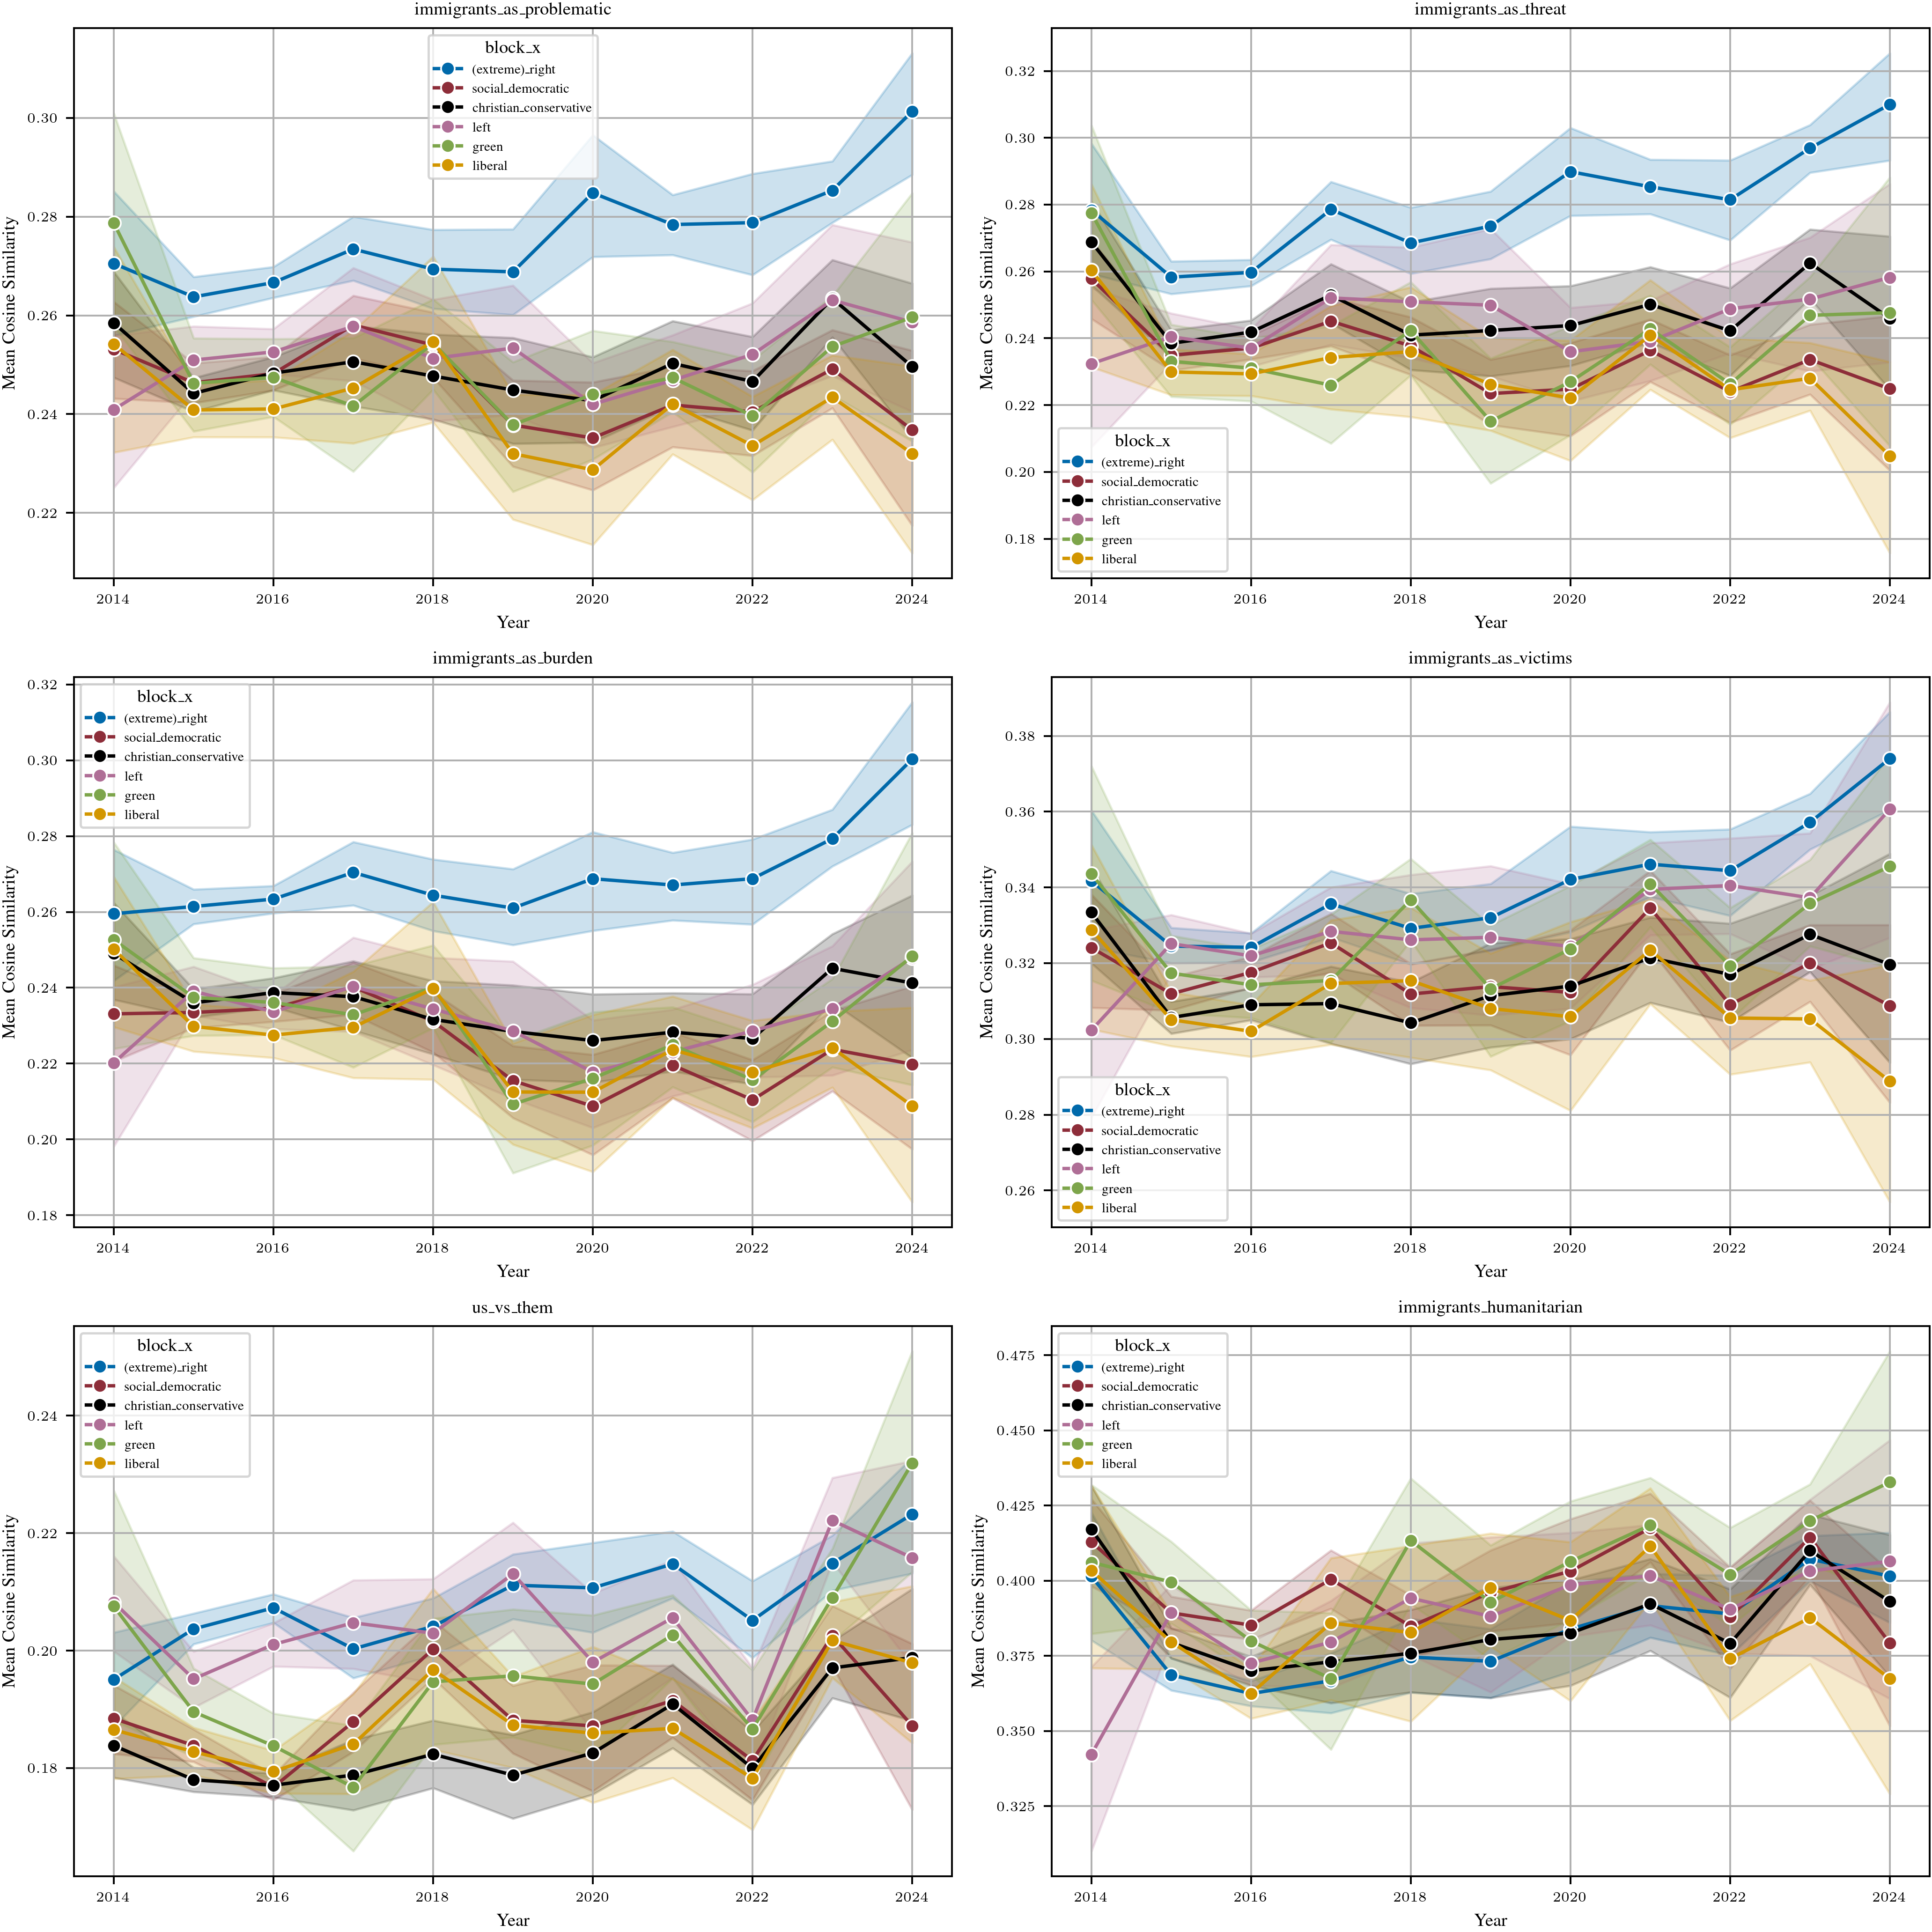

In [17]:
# plot average similarity for each category
categories = list(queries_jrc.keys())
fig, axes = plt.subplots(len(categories)//2, 2, figsize=(12, 4 * len(categories)//2))
for ax, category in zip(axes.flatten(), categories):
    mean_similarity_plots(ax, df, category)
plt.tight_layout()
plt.show()

## Use CHES ratings of immigration policy to check whether embeddings and cosine similarities actually reflect political positions

In [18]:
def ches_vs_narratives(ches_dims, narratives):
    bins = pd.IntervalIndex.from_tuples([(0,2), (2,4), (4,6), (6,8), (8,10)])
    for ches_dim in ches_dims:
        for narrative in narratives:
            df[f"{ches_dim}_cat"] = pd.cut(df[ches_dim], bins=bins)
            plt.figure()
            sns.lineplot(data=df, x='year_x', y=narrative, hue=f"{ches_dim}_cat", marker='o', errorbar='ci', palette='plasma')
            plt.title(f"{narrative} by {ches_dim} categories")
            plt.ylabel("Mean Cosine Similarity")
            plt.xlabel("Year")
            plt.xlim(df['year_x'].min(), df['year_x'].max())
            plt.legend().remove()
            plt.grid(True)
            plt.show()

In [ ]:
# handle CHES data
ches_dims = const.CHES_DIMENSIONS.copy()

# delete all rows where years is not in year_ches
ches_years = df['year_ches'].unique()
df_ches = df[df['year_x'].isin(ches_years)].copy()


In [ ]:
# investigate proportions of missing CHES data per dimension
for dim in const.CHES_DIMENSIONS:
    missing_prop = df_ches[dim].isna().mean()
    print(f"Proportion of missing data for {dim}: {missing_prop:.2%}")
    # print number of existing data points
    print(f"Number of existing data points for {dim}: {df_ches[dim].notna().sum()}")
    # exclude dimensions with more than 80% missing data
    if missing_prop > 0.80:
        ches_dims.remove(dim) 


Proportion of missing data for lrgen: 9.05%
Number of existing data points for lrgen: 683
Proportion of missing data for lrecon: 9.05%
Number of existing data points for lrecon: 683
Proportion of missing data for lrecon_salience: 9.19%
Number of existing data points for lrecon_salience: 682
Proportion of missing data for lrecon_dissent: 43.81%
Number of existing data points for lrecon_dissent: 422
Proportion of missing data for lrecon_blur: 42.88%
Number of existing data points for lrecon_blur: 429
Proportion of missing data for galtan: 9.05%
Number of existing data points for galtan: 683
Proportion of missing data for galtan_salience: 9.19%
Number of existing data points for galtan_salience: 682
Proportion of missing data for galtan_dissent: 43.01%
Number of existing data points for galtan_dissent: 428
Proportion of missing data for galtan_blur: 42.88%
Number of existing data points for galtan_blur: 429
Proportion of missing data for eu_position: 9.05%
Number of existing data points f

In [ ]:
# correlation matrix between CHES dimensions and migration narratives
narratives = ["immigrants_as_problematic", "immigrants_as_threat", "immigrants_humanitarian"]
topn_correlations = 3

# Bonferroni correction for multiple testing
alpha = 0.05
num_tests = len(narratives) * len(ches_dims)
corrected_alpha = alpha / num_tests
print(f"Corrected alpha after Bonferroni correction: {corrected_alpha:.6f}")

# compute correlations and p-values
significance_data = {}
for ches_dim in ches_dims:
    for narrative in narratives:
        df_subset = df_ches.dropna(subset=[narrative, ches_dim])
        if len(df_subset) > 10:
            cor, p_value = stats.pearsonr(df_subset[narrative], df_subset[ches_dim])
            significance_data[(ches_dim, narrative)] = (cor, p_value, p_value < corrected_alpha)
        else:
            significance_data[(ches_dim, narrative)] = (np.nan, np.nan, False)

# keep top n correlations per narrative
top_significance_data = {}
for narrative in narratives:
    corrs = [(ches_dim, *significance_data[(ches_dim, narrative)]) 
             for ches_dim in ches_dims]
    corrs.sort(key=lambda x: abs(x[1]), reverse=True)
    
    for ches_dim, cor, p_value, is_significant in corrs[:topn_correlations]:
        top_significance_data[(ches_dim, narrative)] = (cor, p_value, is_significant)

# build correlation matrix
top_ches_dims = sorted(set(ches_dim for ches_dim, _ in top_significance_data.keys()))
correlation_matrix = pd.DataFrame(index=top_ches_dims, columns=narratives)

for (ches_dim, narrative), (cor, _, _) in top_significance_data.items():
    correlation_matrix.loc[ches_dim, narrative] = cor

correlation_matrix = correlation_matrix.astype(float).dropna(how='all')

# create annotations with correlations and p-values
annot_data = []
for ches_dim in correlation_matrix.index:
    row = []
    for narrative in narratives:
        cor, p_value, _ = top_significance_data.get((ches_dim, narrative), (np.nan, np.nan, False))
        row.append("" if pd.isna(cor) else f"{cor:.3f}\n(p={p_value:.4f})")
    annot_data.append(row)

# plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=annot_data, fmt='', cmap='coolwarm', center=0, 
            cbar_kws={'label': 'Correlation'}, linewidths=0.5)
plt.title(f"Top {topn_correlations} Correlations: CHES Dimensions × Migration Narratives")
plt.xlabel("Migration Narratives")
plt.ylabel("CHES Dimensions")
plt.show()


Corrected alpha after Bonferroni correction: 0.000309


ValueError: `x` and `y` must have length at least 2.

## Construct linear mixed model

In [ ]:
for category in queries_jrc.keys():
    print(f"Fitting mixed effects model for category: {category}")
    model = smf.mixedlm(
        f"{category} ~ year_x * block_x",
        data=df,
        groups="block_x",
        re_formula="~year_x"
    )

    result = model.fit(method="lbfgs")
    print(f"Results for category: {category}")
    print(result.summary())
    print("\n")

Fitting mixed effects model for category: immigrants_as_problematic
Results for category: immigrants_as_problematic
                        Mixed Linear Model Regression Results
Model:                  MixedLM     Dependent Variable:     immigrants_as_problematic
No. Observations:       9705        Method:                 REML                     
No. Groups:             6           Scale:                  0.0039                   
Min. group size:        483         Log-Likelihood:         13065.4760               
Max. group size:        2638        Converged:              Yes                      
Mean group size:        1617.5                                                       
-------------------------------------------------------------------------------------
                                         Coef.   Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
Intercept                                -6.258 

/Users/Quirin/anaconda3/envs/dlit/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Quirin/anaconda3/envs/dlit/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Quirin/anaconda3/envs/dlit/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Quirin/anaconda3/envs/dlit/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/Users/Quirin/anaconda3/envs/dlit/lib/python3.12/site-packages/statsmodels/regre

Results for category: us_vs_them
                       Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          us_vs_them
No. Observations:           9705             Method:                      REML      
No. Groups:                 6                Scale:                       0.0012    
Min. group size:            483              Log-Likelihood:              18829.4324
Max. group size:            2638             Converged:                   Yes       
Mean group size:            1617.5                                                  
------------------------------------------------------------------------------------
                                         Coef.   Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------------------------
Intercept                                -1.413     0.531 -2.663 0.008 -2.453 -0.373
block_x[T.christian_conservative]        -2.356     0.79

/Users/Quirin/anaconda3/envs/dlit/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [ ]:
# save dataframe with computed similarities
df.to_parquet("data/final/migration_with_similarities.parquet")

### Failed Test: Pro - anti contrast axes

In [ ]:
# anti_immigration_axis = {
#     "pro": [
#         "Immigration is bad",
#         "Immigrants’ identity or culture is problematic",
#         "Immigration is a threat to the European way of life and identity",
#         "Arabs and Muslims are a cultural or social threat",
#         "Certain immigrants are unwilling or incapable to integrate",
#         "Immigration is a threat to individual safety",
#         "Immigration is a threat to national security",
#         "Immigrants are prone to committing crimes (violent, non-violent, organised, sexual)",
#         "Many immigrants are terrorists",
#         "Immigrants spread diseases",
#         "There are too many immigrants coming",
#         "Immigrants do not contribute to the economy",
#         "Immigrants take our jobs",
#         "Many asylum seekers are actually economic migrants",
#         "Immigrants abuse the welfare system",
#         "Immigrants are a strain on our health-care system",
#         "Immigrants are a strain on the housing market",
#         "Immigration reduces the attractiveness of location and lowers overall life quality",
#         "Receiving immigrants is too expensive/ immigration burdens tax payers"
#     ],
#     "anti": [
#         "Immigration is not bad",
#         "Immigrants’ identity or culture is not problematic",
#         "Immigration is not a threat to the European way of life and identity",
#         "Arabs and Muslims are not a cultural or social threat",
#         "Most immigrants are willing and able to integrate",
#         "Immigration is not a threat to individual safety",
#         "Immigration is not a threat to national security",
#         "Immigrants are not more prone to committing crimes than others",
#         "Immigrants are not terrorists",
#         "Immigrants do not spread diseases",
#         "The number of immigrants is manageable",
#         "Immigrants contribute to the economy",
#         "Immigrants do not take jobs from others",
#         "Most asylum seekers are genuine refugees",
#         "Immigrants do not abuse the welfare system",
#         "Immigrants are not a strain on the health-care system",
#         "Immigrants are not a strain on the housing market",
#         "Immigration does not reduce quality of life",
#         "Receiving immigrants is not too expensive and does not overly burden taxpayers"
#     ]
# }


In [ ]:
# pro_texts = anti_immigration_axis["pro"]
# anti_texts = anti_immigration_axis["anti"] 
# axes = {}

# for i, (pro, anti) in enumerate(zip(pro_texts, anti_texts)):
#     pro_emb = model.encode_query(pro, normalize_embeddings=True)
#     anti_emb = model.encode_query(anti, normalize_embeddings=True)

#     axis = pro_emb - anti_emb
#     axis /= np.linalg.norm(axis)

#     axes[i] = {
#         "pro": pro,
#         "anti": anti,
#         "axis": axis
#     }

In [ ]:
# speech_embeddings = np.vstack(df[MODEL_NAME].values)
# for i, axis in enumerate(axes.values()):
#     column_name = pro_texts[i]
#     df[column_name] = np.array([emb @ axis["axis"] for emb in speech_embeddings])

In [ ]:
# pro_embeddings = model.encode_query(anti_immigration_axis["pro"], batch_size=32)
# anti_embeddings = model.encode_query(anti_immigration_axis["anti"], batch_size=32)
# axis = np.mean(pro_embeddings, axis=0) - np.mean(anti_embeddings, axis=0)
# axis = axis / np.linalg.norm(axis)  # unit length

# # for every embedding, compute its axis
# for embedding 
# axis = np.mean(pro_embeddings, axis=0) - np.mean(anti_embeddings, axis=0)
# axis = axis / np.linalg.norm(axis)  # unit length

In [ ]:
# queries = pro_texts
# fig, axes = plt.subplots(len(queries)//2, 2, figsize=(12, 4 * len(queries)//2))
# for ax, query in zip(axes.flatten(), queries):
#     mean_similarity_plots(ax, df, query)
#     # on first pass, set legend
#     if ax == axes.flatten()[0]:
#         ax.legend(title='Party Block')

# plt.tight_layout()
# plt.show()